<a href="https://www.kaggle.com/code/ndannnop/computer-vision?scriptVersionId=240059388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pybcf pysam keras-layer-normalization

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 73.2 MB/s eta 0:00:00:00:0100:01
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4654 sha256=5737a2d2b58abc082e614d469f7b8de75bb9b9d36a0bdb655f9afe4f52b34c81
  Stored in directory: /root/.cache/pip/wheels/0f/c4/a1/24f1ca7fd39e75f4d8dab7feda6fe3e2163d8062b29f1169fb
Successfully built keras-layer-normalization


In [2]:
# import libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import os
import random
import math # Needed for ceiling division
    
class BCFImagePatchDataset(Dataset):
    """
    PyTorch Dataset for loading either images from a BCF file or from a folder of JPEG files,
    and extracting patches on the fly. Loads images as grayscale.
    """
    def __init__(self, data_source, label_file=None, num_patch=3, patch_size=(105, 105)):
        """
        Initializes the dataset. Can handle both BCF files and JPEG images.

        Args:
            data_source (str): Path to the BCF file or directory containing JPEG images.
            label_file (str): Path to the label file (required only for BCF files).
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): (height, width) of patches.
        """
        self.data_source = data_source
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size

        self.labels = None
        self.image_filenames = []

        # Determine whether the dataset is based on BCF or JPEG files
        if data_source.endswith('.bcf'):
            self._read_bcf_metadata()
        else:
            self._read_image_filenames()

    def _read_bcf_metadata(self):
        """Reads labels and image size/offset information from BCF files."""
        try:
            # Read label file
            if not self.label_file:
                raise ValueError("Label file is required for BCF data source.")
            with open(self.label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Read {len(self.labels)} labels.")

            # Read BCF header
            with open(self.data_source, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"BCF header indicates {self.num_images} images.")

                if len(self.labels) != self.num_images:
                    raise ValueError(f"Mismatch between number of labels ({len(self.labels)}) and images in BCF header ({self.num_images}).")

                # Read all image sizes
                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)
                print(f"Read {len(self.image_sizes)} image sizes.")

                # Calculate the starting offset of the actual image data blob
                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])
                print("Calculated image offsets.")

        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading metadata: {e}")
            raise

    def _read_image_filenames(self):
        """Reads image filenames from a folder (only for JPEG images)."""
        try:
            # List all JPEG images in the folder
            self.image_filenames = [f for f in os.listdir(self.data_source) if f.endswith('.jpeg') or f.endswith('.jpg')]
            print(f"Found {len(self.image_filenames)} JPEG images.")

            if len(self.image_filenames) == 0:
                raise ValueError("No JPEG images found in the specified folder.")
        except FileNotFoundError as e:
            print(f"Error: Folder not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading filenames: {e}")
            raise

    def __len__(self):
        """Returns the total number of images in the dataset."""
        if hasattr(self, 'num_images'):
            return self.num_images  # For BCF files
        return len(self.image_filenames)  # For JPEG images

    def __getitem__(self, idx):
        """
        Loads one image as grayscale, extracts patches, and returns patches with the label.
    
        Args:
            idx (int): The index of the image to retrieve.
    
        Returns:
            tuple: (list[np.ndarray], int): A tuple containing:
                     - A list of NumPy arrays, each representing a patch (H, W).
                     - The integer label for the image (or 0 for JPEG).
                   Returns ([], -1) if image reading or patch extraction fails.
        """
        if hasattr(self, 'num_images'):  # BCF source
            if idx >= self.num_images or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {self.num_images} images.")
    
            label = self.labels[idx]
            offset = self.image_offsets[idx]
            size = self.image_sizes[idx]
    
            try:
                with open(self.data_source, 'rb') as f:
                    f.seek(self.data_start_offset + offset)
                    image_bytes = f.read(size)
    
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, label
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error
    
        else:  # JPEG source
            if idx >= len(self.image_filenames) or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {len(self.image_filenames)} images.")
    
            image_filename = self.image_filenames[idx]
            image_path = os.path.join(self.data_source, image_filename)
    
            try:
                img = Image.open(image_path).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, 0
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error

def patch_collate_fn(batch, patch_size_tuple):
    """
    Collates data from the BCFImagePatchDataset (handling grayscale) or JPEG-based dataset.

    Takes a batch of [(patches_list_img1, label1), (patches_list_img2, label2), ...],
    flattens the patches, converts them to a tensor, adds a channel dimension,
    normalizes, and returns a single batch tensor for patches and labels.

    Args:
        batch (list): A list of tuples, where each tuple is the output
                      of BCFImagePatchDataset.__getitem__.
        patch_size_tuple (tuple): The (height, width) of patches, needed for empty tensor shape.

    Returns:
        tuple: (torch.Tensor, torch.Tensor): A tuple containing:
                 - Patches tensor (BatchSize * NumPatches, 1, Height, Width)
                 - Labels tensor (BatchSize * NumPatches)
    """
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    for item in batch:
        patches, label = item
        # Ensure item is valid (e.g., image wasn't too small, no read errors)
        if patches and label != -1:
            # Only add patches if the list is not empty
            all_patches.extend(patches)
            # Repeat the label for each patch extracted from the image
            all_labels.extend([label] * len(patches))
            valid_batch_items += 1

    # If no valid patches were collected in the batch (e.g., all images too small)
    if not all_patches:
        # Return empty tensors of appropriate type but 0 size in the batch dimension
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Convert list of NumPy arrays (each H, W) to a single NumPy array
    patches_np = np.array(all_patches)  # Shape: (TotalPatches, H, W)

    # Convert to PyTorch tensor, normalize
    patches_tensor = torch.tensor(patches_np).float() / 255.0  # Shape: (TotalPatches, H, W)

    # Add channel dimension: (TotalPatches, H, W) -> (TotalPatches, 1, H, W)
    patches_tensor = patches_tensor.unsqueeze(1)

    # Convert labels to PyTorch tensor
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # Use long for classification labels

    return patches_tensor, labels_tensor

In [3]:
import easyocr
import numpy as np
import os
import tempfile
from PIL import Image

# Global OCR reader for efficiency
_ocr_reader = None

def get_ocr_reader(languages=["en"]):
    """Get or initialize the EasyOCR reader"""
    global _ocr_reader
    if _ocr_reader is None:
        _ocr_reader = easyocr.Reader(languages)
    return _ocr_reader

def extract_patches(image_array, num_patch=3, patch_size=(105, 105), 
                    extract_text=True, min_text_coverage=0.3, max_attempts=20):
    """
    Extracts patches from an image, prioritizing those containing text if extract_text=True.
    If we can't find enough text patches after max_attempts, returns whatever was found.
    
    Args:
        image_array (np.ndarray): The input image (Height, Width) or (Height, Width, Channels).
        num_patch (int): The number of patches to extract.
        patch_size (tuple): The (height, width) of the patches.
        extract_text (bool): Whether to prioritize text-containing patches
        min_text_coverage (float): Minimum ratio of text area to patch size (0-1)
        max_attempts (int): Maximum number of random patches to try
        
    Returns:
        list[np.ndarray]: A list containing the extracted patch arrays.
                          May contain fewer than num_patch elements if text patches couldn't be found.
    """
    # Handle dimension check
    if image_array.ndim == 2:  # Grayscale
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3:  # Color
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Warning: Unexpected image array dimension: {image_array.ndim}")
        return []

    patch_h, patch_w = patch_size

    # Check if image is large enough for at least one patch
    if h < patch_h or w < patch_w:
        return []  # Return empty list if image is too small
        
    # If not extracting text or image is too small, use random patches
    if not extract_text:
        patches = []
        for _ in range(num_patch):
            x = np.random.randint(0, w - patch_w + 1)
            y = np.random.randint(0, h - patch_h + 1)
            if is_grayscale:
                patch = image_array[y:y+patch_h, x:x+patch_w]
            else:
                patch = image_array[y:y+patch_h, x:x+patch_w, :]
            patches.append(patch)
        return patches
        
    # For text extraction, we'll try to find patches with text
    reader = get_ocr_reader()
    text_patches = []
    attempts = 0
    
    # Keep extracting until we have enough or reach max attempts
    while len(text_patches) < num_patch and attempts < max_attempts:
        # Generate a random patch
        x = np.random.randint(0, w - patch_w + 1)
        y = np.random.randint(0, h - patch_h + 1)
        
        if is_grayscale:
            patch = image_array[y:y+patch_h, x:x+patch_w]
        else:
            patch = image_array[y:y+patch_h, x:x+patch_w, :]
            
        # Save patch to temporary file for OCR
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
            tmp_path = tmp.name
            patch_img = Image.fromarray(patch if is_grayscale else patch)
            patch_img.save(tmp_path)
            
        try:
            # Run OCR on the patch
            ocr_results = reader.readtext(tmp_path)
            
            # Clean up temp file
            os.unlink(tmp_path)
            
            # Calculate total text area
            patch_area = patch_h * patch_w
            text_area = 0
            
            for bbox, text, conf in ocr_results:
                if conf < 0.5:  # Skip low confidence detections
                    continue
                    
                # Convert bbox points to integers
                bbox = [[int(point[0]), int(point[1])] for point in bbox]
                
                # Calculate bbox area (text area)
                text_min_x = max(0, min(point[0] for point in bbox))
                text_max_x = min(patch_w, max(point[0] for point in bbox))
                text_min_y = max(0, min(point[1] for point in bbox))
                text_max_y = min(patch_h, max(point[1] for point in bbox))
                
                box_width = text_max_x - text_min_x
                box_height = text_max_y - text_min_y
                
                if box_width > 0 and box_height > 0:
                    text_area += box_width * box_height
            
            # Check if patch has enough text
            coverage = text_area / patch_area
            if coverage >= min_text_coverage:
                text_patches.append(patch)
                # print(f"Found text patch with coverage {coverage:.2f}")
        
        except Exception as e:
            print(f"Error in OCR: {e}")
            try:
                os.unlink(tmp_path)
            except:
                pass
                
        attempts += 1
    
    # Return whatever text patches we found, even if fewer than requested
    return text_patches

In [4]:
# combined dataset
import torch
from PIL import Image
import numpy as np
import os
from io import BytesIO
from datasets import Dataset

class CombinedImageDataset(Dataset):
    """
    A dataset class that combines both .jpeg files and .bcf files into a single dataset.
    This class can handle loading and patch extraction from both .jpeg and .bcf files.
    """
    def __init__(self, jpeg_dir, bcf_file, label_file, num_patch=3, patch_size=(105, 105), 
                 extract_text=False, min_text_coverage=0.3, max_attempts=20, ocr_languages=["en"]):
        """
        Initializes the dataset by loading both jpeg files and bcf files into one dataset.

        Args:
            jpeg_dir (str): Directory containing .jpeg files.
            bcf_file (str): Path to the .bcf file.
            label_file (str): Path to the label file corresponding to the .bcf file.
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): Tuple (height, width) for the size of the patches.
            extract_text (bool): Whether to prioritize patches containing text
            min_text_coverage (float): Minimum ratio of text area to patch area (0-1)
            max_attempts (int): Maximum number of attempts to find text patches
            ocr_languages (list): Languages for EasyOCR to detect
        """
        self.jpeg_dir = jpeg_dir
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size
        self.extract_text = extract_text
        self.min_text_coverage = min_text_coverage
        self.max_attempts = max_attempts
        self.ocr_languages = ocr_languages

        # Initialize OCR reader if needed
        if extract_text:
            self.reader = get_ocr_reader(ocr_languages)

        self.jpeg_data = []
        self.bcf_data = []

        # Load jpeg data
        self._load_jpeg_data(jpeg_dir)

        # Load bcf data
        self._load_bcf_data(bcf_file, label_file)

    def _load_jpeg_data(self, jpeg_dir):
        """Loads the .jpeg files from the specified directory."""
        if not os.path.exists(jpeg_dir):
            print(f"Warning: JPEG directory {jpeg_dir} does not exist.")
            return
            
        image_filenames = [f for f in os.listdir(jpeg_dir) if f.lower().endswith(('.jpeg', '.jpg'))]
        self.jpeg_data = [(os.path.join(jpeg_dir, f), 0) for f in image_filenames]  # Assuming label is 0 for .jpeg files
        print(f"Loaded {len(self.jpeg_data)} .jpeg images.")

    def _load_bcf_data(self, bcf_file, label_file):
        """Loads the .bcf file and the associated label file."""
        if not (os.path.exists(bcf_file) and os.path.exists(label_file)):
            print(f"Warning: BCF file {bcf_file} or label file {label_file} does not exist.")
            return
            
        try:
            with open(label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Loaded {len(self.labels)} labels from {label_file}.")

            with open(bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"Loaded {self.num_images} images from {bcf_file}.")

                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)

                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])

                for idx in range(self.num_images):
                    self.bcf_data.append((idx, self.labels[idx]))
                
            print(f"Loaded {len(self.bcf_data)} .bcf images.")
        except Exception as e:
            print(f"Error loading .bcf data: {e}")

    def __len__(self):
        """Returns the total number of images in the combined dataset."""
        return len(self.jpeg_data) + len(self.bcf_data)

    def _extract_patches(self, img_array):
        """Helper function to extract patches from an image."""
        return extract_patches(
            img_array, 
            num_patch=self.num_patch, 
            patch_size=self.patch_size,
            extract_text=self.extract_text, 
            min_text_coverage=self.min_text_coverage,
            max_attempts=self.max_attempts
        )

    def __getitem__(self, idx):
        """Fetches one item with robust error handling for corrupted images."""
        # Handle case where idx is a list (batch loading)
        if isinstance(idx, list):
            # Handle batch indices properly
            results = []
            labels = []
            for single_idx in idx:
                try:
                    patches, label = self.__getitem__(single_idx)  # Call recursively with single index
                    if patches and label != -1:
                        results.append(patches)
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing index {single_idx}: {e}")
                    # Skip this item on error
            
            # Return whatever valid items we were able to get
            return results, labels
        
        # Original single-item loading logic
        max_retries = 3  # Try a few times before giving up on an index
        
        for retry in range(max_retries):
            try:
                if idx < len(self.jpeg_data):
                    # JPEG image with error handling
                    img_path, label = self.jpeg_data[idx]
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")  # Ignore PIL warnings
                            img = Image.open(img_path)
                            img.verify()  # Verify image is not corrupted
                        
                        # Re-open since verify() closes the file
                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        
                        # Clean memory
                        del img, img_array
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        # Image is corrupted, return empty list
                        print(f"Warning: Corrupt image at {img_path}: {e}")
                        return [], -1
                        
                else:
                    # BCF image with error handling
                    bcf_idx = idx - len(self.jpeg_data)
                    if bcf_idx >= len(self.bcf_data):
                        return [], -1
                        
                    label = self.bcf_data[bcf_idx][1]
                    offset = self.image_offsets[bcf_idx]
                    size = self.image_sizes[bcf_idx]
                    
                    try:
                        with open(self.bcf_file, 'rb') as f:
                            f.seek(self.data_start_offset + offset)
                            image_bytes = f.read(size)
                        
                        # Use BytesIO to catch corruption
                        buffer = BytesIO(image_bytes)
                        img = Image.open(buffer)
                        img.verify()  # Verify it's valid
                        
                        # Re-open since verify() closes the file
                        buffer.seek(0)
                        img = Image.open(buffer).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        
                        # Clean memory
                        del img, img_array, buffer, image_bytes
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt BCF image at index {bcf_idx}: {e}")
                        return [], -1
                        
            except Exception as e:
                print(f"Unexpected error processing idx {idx}: {e}")
            
            # If we got here, there was an issue with this index - try a different one
            # Important: increment as an integer, not trying to add to a list
            if retry < max_retries - 1:  # Only increment if we have retries left
                idx = (int(idx) + 1) % len(self)
        
        # If all retries failed, return empty
        return [], -1

In [28]:
len((combined_dataset)[0][0][0])

105

In [5]:
# memory_efficient_patch_collate_fn
import gc
import warnings
from functools import partial

# Add this memory-efficient patch collate function
def memory_efficient_patch_collate_fn(batch, patch_size_tuple):
    """
    Memory-efficient version of patch_collate_fn that processes one patch at a time
    and includes robust error handling.
    """
    import gc  # Import inside function for worker processes
    
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    # Process one item at a time to avoid large memory allocations
    for item in batch:
        patches, label = item
        # Ensure item is valid
        if patches and label != -1:
            # Process patches one by one
            for patch in patches:
                all_patches.append(patch)
                all_labels.append(label)
            valid_batch_items += 1
    
    # Periodically force garbage collection
    if len(all_patches) > 100:
        gc.collect()
    
    # Empty batch handling
    if not all_patches:
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Process in smaller chunks to reduce peak memory usage
    max_chunk_size = 64  # Adjust based on your GPU memory
    num_patches = len(all_patches)
    patches_tensor_list = []
    
    for i in range(0, num_patches, max_chunk_size):
        chunk = all_patches[i:i+max_chunk_size]
        # Convert to NumPy array
        chunk_np = np.stack(chunk)
        # Convert to tensor, normalize and add channel dimension
        chunk_tensor = torch.from_numpy(chunk_np).float() / 255.0
        chunk_tensor = chunk_tensor.unsqueeze(1)
        patches_tensor_list.append(chunk_tensor)
        
        # Clear variables to free memory
        del chunk, chunk_np
    
    # Concatenate chunks
    patches_tensor = torch.cat(patches_tensor_list, dim=0)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    # Clean up
    del patches_tensor_list, all_patches, all_labels
    gc.collect()
    
    return patches_tensor, labels_tensor

# Add this function to create optimized DataLoaders
import torch
from torch.utils.data import DataLoader
from functools import partial

def create_optimized_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper error handling, avoiding HuggingFace datasets compatibility issues.
    
    Args:
        dataset: The image dataset instance
        batch_size: Batch size for training
        num_workers: Number of worker processes
        val_split: Validation split ratio (0-1)
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    from torch.utils.data import DataLoader, Subset
    import numpy as np
    
    # Calculate split sizes
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets - this avoids Hugging Face's __getitems__ implementation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Custom collate function with error handling
    def safe_collate(batch):
        # Filter out empty or invalid items
        valid_batch = [(patches, label) for patches, label in batch if patches and label != -1]
        
        if not valid_batch:
            # Return empty tensors if no valid items
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
        
        # Process valid items
        all_patches = []
        all_labels = []
        
        for patches, label in valid_batch:
            if isinstance(patches, list) and patches:
                all_patches.extend(patches)
                all_labels.extend([label] * len(patches))
        
        if not all_patches:
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
            
        # Convert to PyTorch tensors
        try:
            patches_np = np.array(all_patches)
            patches_tensor = torch.tensor(patches_np, dtype=torch.float) / 255.0
            
            # Add channel dimension if needed
            if len(patches_tensor.shape) == 3:  # (B, H, W)
                patches_tensor = patches_tensor.unsqueeze(1)  # -> (B, 1, H, W)
                
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders with minimal worker configuration for stability
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=True if num_workers > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=True if num_workers > 0 else False
    )
    
    return train_loader, val_loader

In [44]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
import gc


class DatasetWrapper(Dataset):
    """
    A wrapper for your dataset to ensure compatibility with DataLoader
    """
    def __init__(self, original_dataset):
        self.dataset = original_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get a single item by index, handling both direct dataset access
        # and access through Subset indices
        try:
            # Handle if we're accessing through a Subset
            if hasattr(self.dataset, 'dataset') and hasattr(self.dataset, 'indices'):
                original_idx = self.dataset.indices[idx]
                return self.dataset.dataset[original_idx]
            # Normal access
            return self.dataset[idx]
        except Exception as e:
            print(f"Error accessing item {idx}: {e}")
            # Return a placeholder for invalid items
            return [], -1


def create_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper handling for HuggingFace datasets.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Custom collate function
    def custom_collate_fn(batch):
        # Filter out invalid items
        batch = [(img, label) for img, label in batch if img is not None and len(img) > 0 and label != -1]
        
        if not batch:
            # Return empty tensors with appropriate dimensions
            return torch.empty((0, 3, 105, 105), dtype=torch.float), torch.empty((0,), dtype=torch.long)
        
        # Extract images and labels
        images, labels = zip(*batch)
        
        # Convert to tensors
        images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in images])
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        
        # Normalize images if needed
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        return images_tensor, labels_tensor
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader


# For datasets where you're dealing with patches
def create_patch_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1, patch_size=(105, 105)):
    """
    Creates DataLoaders specifically for patch-based datasets where each item
    may contain multiple patches.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Memory efficient collate function for patches
    def patch_collate_fn(batch):
        all_patches = []
        all_labels = []
        
        # Process one batch item at a time
        for patches, label in batch:
            if patches is not None and len(patches) > 0 and label != -1:
                # Handle both single patches and lists of patches
                if isinstance(patches, list):
                    all_patches.extend(patches)
                    all_labels.extend([label] * len(patches))
                else:
                    all_patches.append(patches)
                    all_labels.append(label)
        
        # Return empty tensors if batch is empty
        if not all_patches:
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
            
        try:
            # Process in chunks to reduce memory usage
            max_chunk_size = min(64, len(all_patches))
            patches_tensors = []
            
            for i in range(0, len(all_patches), max_chunk_size):
                chunk = all_patches[i:i+max_chunk_size]
                chunk_tensor = torch.stack([torch.tensor(p, dtype=torch.float) for p in chunk])
                
                # Normalize if needed
                if chunk_tensor.max() > 1.0:
                    chunk_tensor = chunk_tensor / 255.0
                    
                patches_tensors.append(chunk_tensor)
                
            # Combine chunks
            patches_tensor = torch.cat(patches_tensors, dim=0).unsqueeze(1)
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            
            # Clean up to save memory
            del patches_tensors, all_patches, all_labels
            gc.collect()
            
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader

train_loader, val_loader = create_patch_dataloaders(
    combined_dataset,
    batch_size=64,
    num_workers=2,
    val_split=0.1,
    patch_size=(105, 105)
)


In [45]:
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {images.size()}, Labels size: {labels.size()}")
    break  # Just check the first batch

Batch size: torch.Size([126, 1, 105, 105]), Labels size: torch.Size([126])


In [35]:
len(val_loader)

445

In [33]:
next(iter(train_loader))

[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0196, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6706, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 0.7333, 0.0588,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [23]:
# load dataset -> create dataloader -> training script
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Available memory: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Create dataset with smaller patch size and fewer patches per image
combined_dataset = CombinedImageDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=3,  # Number of patches per image
)

# Create memory-optimized dataloaders with smaller batch size
train_loader, val_loader = create_optimized_dataloaders(
    combined_dataset,
    batch_size=512,  # Reduced from 1024
    num_workers=2,   # Reduced from 4
)

Using GPU: Tesla P100-PCIE-16GB
Total memory: 17.06 GB
Available memory: 0.00 GB
Loaded 82389 .jpeg images.
Loaded 202000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 202000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 202000 .bcf images.


In [20]:
# Check all elements of combined_dataset for shape consistency
def check_shapes(dataset):
    """
    Check if all patches in the dataset have the same shape.
    
    Args:
        dataset: The dataset instance to check.
        
    Returns:
        bool: True if all patches have the same shape, False otherwise.
    """
    first_shape = None
    for idx in range(len(dataset)):
        patches, _ = dataset[idx]
        if not patches:
            continue  # Skip empty patches
        current_shape = patches[0].shape
        if first_shape is None:
            first_shape = current_shape
        elif current_shape != first_shape:
            print(f"Shape mismatch at index {idx}: {current_shape} != {first_shape}")
            return False
    return True 
check_shapes(combined_dataset)

KeyboardInterrupt: 

In [36]:
# load dataset -> create dataloader -> training script
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Available memory: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Create dataset with smaller patch size and fewer patches per image
combined_dataset = CombinedImageDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=3,  # Reduced from 3
)

# Create memory-optimized dataloaders with smaller batch size
train_loader, val_loader = create_optimized_dataloaders(
    combined_dataset,
    batch_size=512,  # Reduced from 1024
    num_workers=2,   # Reduced from 4
)

Using GPU: Tesla P100-PCIE-16GB
Total memory: 17.06 GB
Available memory: 0.00 GB
Loaded 82389 .jpeg images.
Loaded 202000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 202000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 202000 .bcf images.


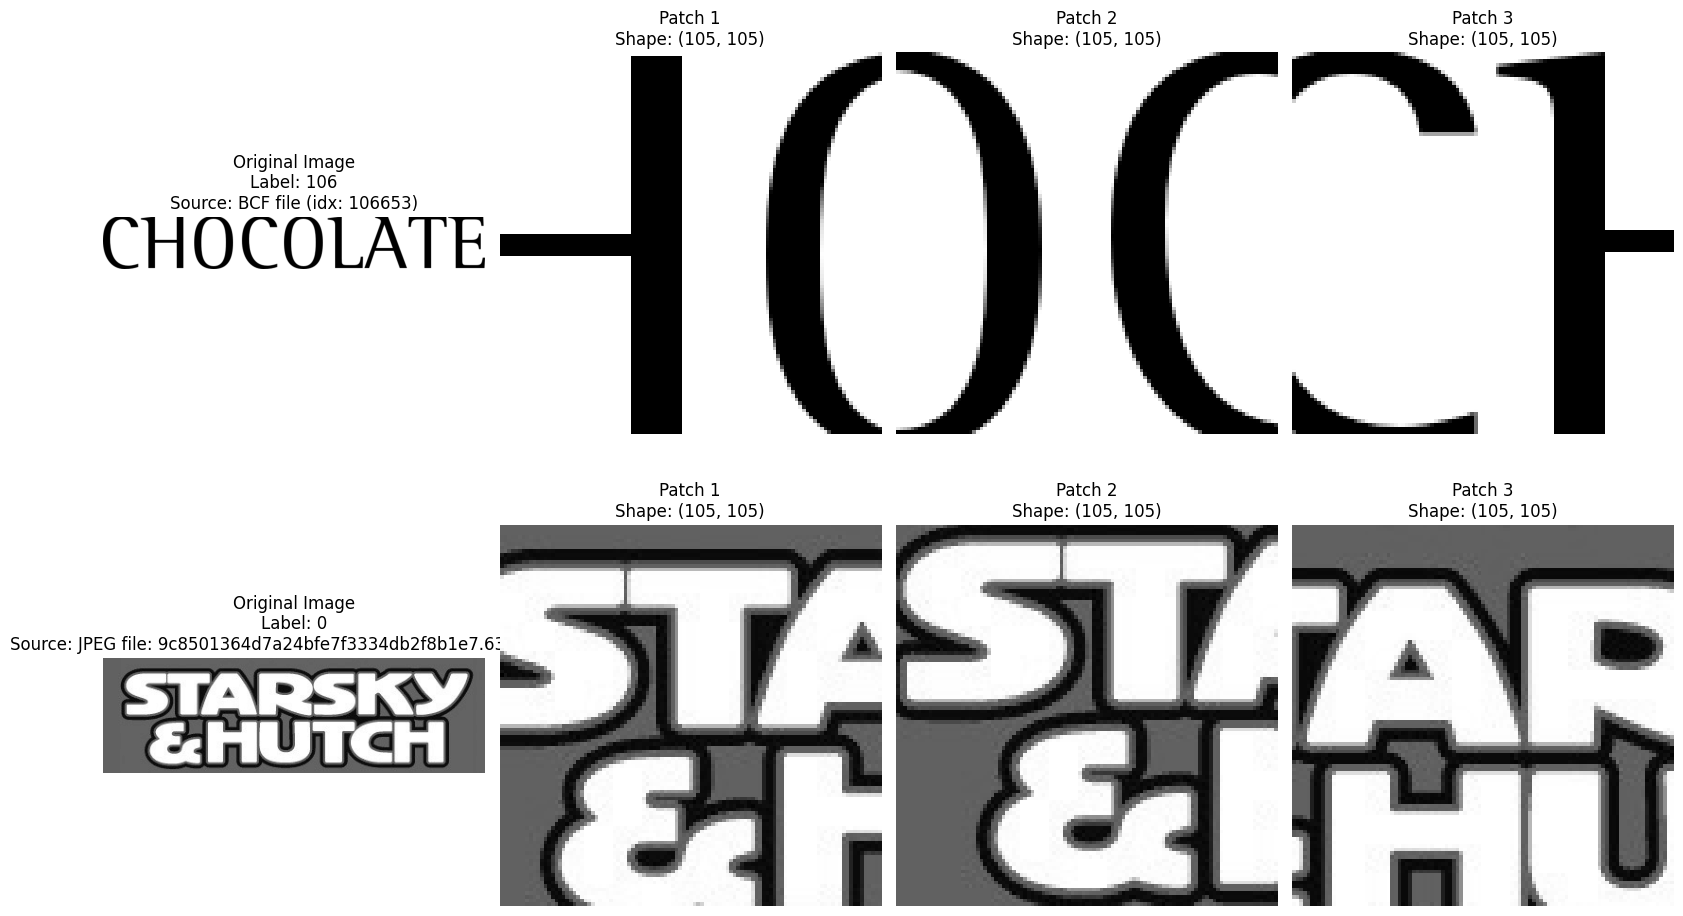

[189042, 69185]

In [36]:
# Visualization some samples from the combined dataset (there's bug now, I'll try to fix it)
def visualize_simple_images_and_patches(dataset, num_images=2, seed=None):
    """
    Visualizes full images and their extracted patches in a simple layout.
    Shows images and their 3 patches in a clean format with error handling.
    
    Args:
        dataset: A CombinedImageDataset or BCFImagePatchDataset instance
        num_images: Number of images to visualize (default: 2)
        seed: Random seed for reproducibility
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    from PIL import Image, ImageFile
    from io import BytesIO
    import os
    
    # Allow loading of truncated images
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Find valid images (with patches)
    valid_indices = []
    attempts = 0
    max_attempts = min(len(dataset) * 2, 100)  # Limit search attempts
    
    while len(valid_indices) < num_images and attempts < max_attempts:
        idx = random.randint(0, len(dataset) - 1)
        if idx not in valid_indices:  # Avoid duplicates
            try:
                patches, label = dataset[idx]
                if patches and len(patches) > 0:
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading index {idx}: {e}")
            attempts += 1
    
    # If we couldn't find enough valid images
    if len(valid_indices) < num_images:
        print(f"Warning: Could only find {len(valid_indices)} valid images with patches")
        if len(valid_indices) == 0:
            print("No valid images found. Check your dataset.")
            return
    
    # Create figure with enough space for all elements
    fig, axes = plt.subplots(len(valid_indices), 4, figsize=(16, 5 * len(valid_indices)))
    
    # If only one image is requested, make axes indexable as 2D
    if len(valid_indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(valid_indices):
        try:
            # Get item directly from dataset
            patches, label = dataset[idx]
            
            # Get the original full image
            img_array = None
            
            if hasattr(dataset, 'jpeg_data') and idx < len(dataset.jpeg_data):
                # From jpeg_data
                img_path, _ = dataset.jpeg_data[idx]
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {os.path.basename(img_path)}"
                
            elif hasattr(dataset, 'image_filenames') and not hasattr(dataset, 'num_images'):
                # From BCFImagePatchDataset with JPEG source
                img_path = os.path.join(dataset.data_source, dataset.image_filenames[idx])
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {dataset.image_filenames[idx]}"
                
            else:
                # From BCF file (either CombinedImageDataset or BCFImagePatchDataset)
                if hasattr(dataset, 'bcf_data'):
                    # CombinedImageDataset
                    bcf_idx = idx - len(dataset.jpeg_data)
                    if bcf_idx < 0 or bcf_idx >= len(dataset.bcf_data):
                        print(f"Invalid BCF index: {bcf_idx}")
                        continue
                        
                    offset = dataset.image_offsets[bcf_idx]
                    size = dataset.image_sizes[bcf_idx]
                    data_file = dataset.bcf_file
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {bcf_idx})"
                else:
                    # BCFImagePatchDataset
                    offset = dataset.image_offsets[idx]
                    size = dataset.image_sizes[idx]
                    data_file = dataset.data_source
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {idx})"
                
                with open(data_file, 'rb') as f:
                    f.seek(data_start + offset)
                    image_bytes = f.read(size)
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
            
            # Plot original image if we successfully loaded it
            if img_array is not None:
                axes[i, 0].imshow(img_array, cmap='gray')
                axes[i, 0].set_title(f"Original Image\nLabel: {label}\nSource: {source}")
                axes[i, 0].axis('off')
            else:
                axes[i, 0].text(0.5, 0.5, "Image loading failed", ha='center', va='center')
                axes[i, 0].axis('off')
            
            # Plot the patches - ensure we have patches to display
            if patches and len(patches) > 0:
                for j in range(3):
                    if j < len(patches):
                        patch = patches[j]
                        axes[i, j+1].imshow(patch, cmap='gray')
                        axes[i, j+1].set_title(f"Patch {j+1}\nShape: {patch.shape}")
                    else:
                        # No more patches to display
                        axes[i, j+1].text(0.5, 0.5, "No patch", ha='center', va='center')
                    axes[i, j+1].axis('off')
            else:
                # No patches for this image
                for j in range(3):
                    axes[i, j+1].text(0.5, 0.5, "No patches extracted", ha='center', va='center')
                    axes[i, j+1].axis('off')
            
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            # Create error message in subplot
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return the indices we used (helpful for debugging)
    return valid_indices

# Example usage:
visualize_simple_images_and_patches(combined_dataset)

In [48]:
sample = next(iter(train_loader))

In [40]:
# train_memory_efficient_model

import torch.cuda.amp as amp
import gc

def train_memory_efficient_model(model, train_loader, val_loader=None, 
                                num_epochs=5, learning_rate=0.0001,
                                checkpoint_dir="/kaggle/working/"):
    """
    Memory-efficient training function for SCAE model.
    """
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup device and optimization tools
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device} with {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")
    
    # Move model to device
    model = model.to(device)
    
    # Set up mixed precision training
    scaler = amp.GradScaler()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # Track best model
    best_val_loss = float('inf')
    patience_counter = 0
    
    try:
        for epoch in range(num_epochs):
            # Clean memory before each epoch
            gc.collect()
            torch.cuda.empty_cache()
            
            # TRAINING PHASE
            model.train()
            running_loss = 0.0
            valid_batches = 0
            
            # Use tqdm for progress tracking
            pbar = tqdm(train_loader)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train]")
            
            for batch_idx, (patches, _) in enumerate(pbar):
                # Skip empty batches
                if patches.numel() == 0:
                    continue
                
                # Move data to device
                patches = patches.to(device, non_blocking=True)
                
                # Mixed precision forward pass
                with amp.autocast():
                    outputs = model(patches)
                    loss = criterion(outputs, patches)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update metrics
                running_loss += loss.item()
                valid_batches += 1
                
                # Update progress bar
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                
                # Aggressive memory cleanup every few batches
                if batch_idx % 10 == 0:
                    del outputs, loss, patches
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            # Calculate epoch metrics
            if valid_batches > 0:
                train_loss = running_loss / valid_batches
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, No valid batches!")
                continue
                
            # Save checkpoint every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
            
            # VALIDATION PHASE
            if val_loader:
                val_loss = validate_memory_efficient(model, val_loader, criterion, device)
                scheduler.step(val_loss)
                
                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pt")
                    print(f"New best model saved with val_loss: {val_loss:.6f}")
                else:
                    patience_counter += 1
                    if patience_counter >= 3:  # Adjust patience as needed
                        print("Early stopping triggered!")
                        break
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Save emergency checkpoint
        torch.save(model.state_dict(), f"{checkpoint_dir}/emergency_model.pt")
        raise
        
    return model

def validate_memory_efficient(model, val_loader, criterion, device):
    """Memory-efficient validation function."""
    model.eval()
    running_loss = 0.0
    valid_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"Validating")
        
        for patches, _ in pbar:
            if patches.numel() == 0:
                continue
                
            patches = patches.to(device, non_blocking=True)
            
            # Using mixed precision even for validation
            with amp.autocast():
                outputs = model(patches)
                loss = criterion(outputs, patches)
                
            running_loss += loss.item()
            valid_batches += 1
            
            # Update progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
            # Clean up
            del outputs, patches, loss
    
    if valid_batches > 0:
        val_loss = running_loss / valid_batches
        print(f"Validation Loss: {val_loss:.6f}")
        return val_loss
    else:
        print("No valid validation batches!")
        return float('inf')

In [ ]:
# SCAE
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="leaky_relu"):
        super(SCAE, self).__init__()

        def norm_layer(num_features):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm":
                return nn.LayerNorm([num_features, 26, 26])  # Adjusted for bottleneck size
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=1, padding=5),  # 105x105 -> 105x105
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2),  # 105x105 -> 52x52

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 52x52 -> 52x52
            norm_layer(128),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2)  # 52x52 -> 26x26
        )

        # Decoder - Using U-Net style architecture with precise sizing
        self.decoder = nn.Sequential(
            # First upsampling: 26x26 -> 52x52
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            # Second upsampling: 52x52 -> 105x105
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0, output_padding=1),
            norm_layer(32),
            activation_layer(),
            dropout_layer(),

            # Final convolution to get single channel
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # For image reconstruction (values between 0-1)
        )

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
            # print(x.shape)
        for layer in self.decoder:
            x = layer(x)
            # print(x.shape)
        return x

In [38]:
# SCAE (Tu's version)
import torch
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="relu"):
        super(SCAE, self).__init__()
        def norm_layer(num_features):
            if normalization_type == "batch_norm": return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm": return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm": return nn.LayerNorm([num_features, 48, 48])
            else: return nn.Identity()
        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)
        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder: conv1 → pool1 → conv2
        self.conv1 = nn.Conv2d(1, 64, kernel_size=11, stride=2, padding=0)  # 105x105 → 48x48
        self.norm1 = norm_layer(64)
        self.act1 = activation_layer()
        self.drop1 = dropout_layer()
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)                # 48x48 → 24x24

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 24x24 → 24x24
        self.norm2 = norm_layer(128)
        self.act2 = activation_layer()
        self.drop2 = dropout_layer()

        # Decoder: deconv1 → unpool1 → deconv2
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1) # 24x24 → 24x24
        self.norm3 = norm_layer(64)
        self.act3 = activation_layer()
        self.drop3 = dropout_layer()
        self.unpool1 = nn.MaxUnpool2d(2, 2)                                           # 24x24 → 48x48

        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=11, stride=2, padding=0) # 48x48 → 105x105
        # No normalization/activation after last layer for output
        self.final_act = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x, indices = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        x = self.drop2(x)
        # Decoder
        x = self.deconv1(x)
        x = self.norm3(x)
        x = self.act3(x)
        x = self.drop3(x)
        x = self.unpool1(x, indices, output_size=torch.Size([x.size(0), x.size(1), 48, 48]))
        x = self.deconv2(x)
        x = self.final_act(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SCAE().to(device)

In [37]:
len(train_loader)

4000

In [46]:
# Create model and train with memory optimization

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SCAE().to(device)
trained_model = train_memory_efficient_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=0.0001
)

Training on cuda with Tesla P100-PCIE-16GB
Memory allocated: 0.01 GB
Memory reserved: 0.02 GB


/tmp/ipykernel_31/3528968233.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/4000 [00:00<?, ?it/s]/tmp/ipykernel_31/3528968233.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/10 [Train]: 100%|██████████| 4000/4000 [17:08<00:00,  3.89it/s, loss=0.0046]


Epoch 1/10, Train Loss: 0.011893


Validating:   0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_31/3528968233.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating: 100%|██████████| 445/445 [01:50<00:00,  4.04it/s, loss=0.0043]


Validation Loss: 0.004536
New best model saved with val_loss: 0.004536


Epoch 2/10 [Train]: 100%|██████████| 4000/4000 [12:31<00:00,  5.32it/s, loss=0.0032]


Epoch 2/10, Train Loss: 0.004034


Validating: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s, loss=0.0029]


Validation Loss: 0.003581
New best model saved with val_loss: 0.003581


Epoch 3/10 [Train]: 100%|██████████| 4000/4000 [12:40<00:00,  5.26it/s, loss=0.0048]


Epoch 3/10, Train Loss: 0.003415


Validating: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s, loss=0.0029]


Validation Loss: 0.003256
New best model saved with val_loss: 0.003256


Epoch 4/10 [Train]: 100%|██████████| 4000/4000 [13:11<00:00,  5.05it/s, loss=0.0026]


Epoch 4/10, Train Loss: 0.003152


Validating: 100%|██████████| 445/445 [01:22<00:00,  5.36it/s, loss=0.0024]


Validation Loss: 0.003050
New best model saved with val_loss: 0.003050


Epoch 5/10 [Train]: 100%|██████████| 4000/4000 [12:34<00:00,  5.30it/s, loss=0.0025]


Epoch 5/10, Train Loss: 0.003017


Validating: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s, loss=0.0025]


Validation Loss: 0.002956
New best model saved with val_loss: 0.002956


Epoch 6/10 [Train]: 100%|██████████| 4000/4000 [12:35<00:00,  5.29it/s, loss=0.0028]


Epoch 6/10, Train Loss: 0.002947


Validating: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s, loss=0.0021]


Validation Loss: 0.002920
New best model saved with val_loss: 0.002920


Epoch 7/10 [Train]: 100%|██████████| 4000/4000 [12:31<00:00,  5.32it/s, loss=0.0021]


Epoch 7/10, Train Loss: 0.002895


Validating: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s, loss=0.0026]


Validation Loss: 0.002873
New best model saved with val_loss: 0.002873


Epoch 8/10 [Train]: 100%|██████████| 4000/4000 [12:37<00:00,  5.28it/s, loss=0.0020]


Epoch 8/10, Train Loss: 0.002862


Validating: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s, loss=0.0020]


Validation Loss: 0.002876


Epoch 9/10 [Train]: 100%|██████████| 4000/4000 [12:31<00:00,  5.32it/s, loss=0.0017]


Epoch 9/10, Train Loss: 0.002832


Validating: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s, loss=0.0023]


Validation Loss: 0.002809
New best model saved with val_loss: 0.002809


Epoch 10/10 [Train]: 100%|██████████| 4000/4000 [12:28<00:00,  5.34it/s, loss=0.0024]


Epoch 10/10, Train Loss: 0.002812


Validating: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s, loss=0.0023]

Validation Loss: 0.002809


In [ ]:
torch.save(model.state_dict(), "/kaggle/working/checkpoint")

Using device: cuda
Model loaded successfully


/tmp/ipykernel_167/2234447316.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 82389 .jpeg images.
Loaded 3202 labels from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label.
Loaded 3202 images from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf.
Loaded 3202 .bcf images.
Dataset and DataLoader prepared

1. Evaluating reconstruction quality...
Reconstruction Metrics:
  Average MSE: 0.0051
  Average SSIM: 0.8099 (higher is better, max 1.0)
  Average PSNR: 22.98 dB (higher is better)
Saved reconstruction comparison to /kaggle/working/evaluation_results


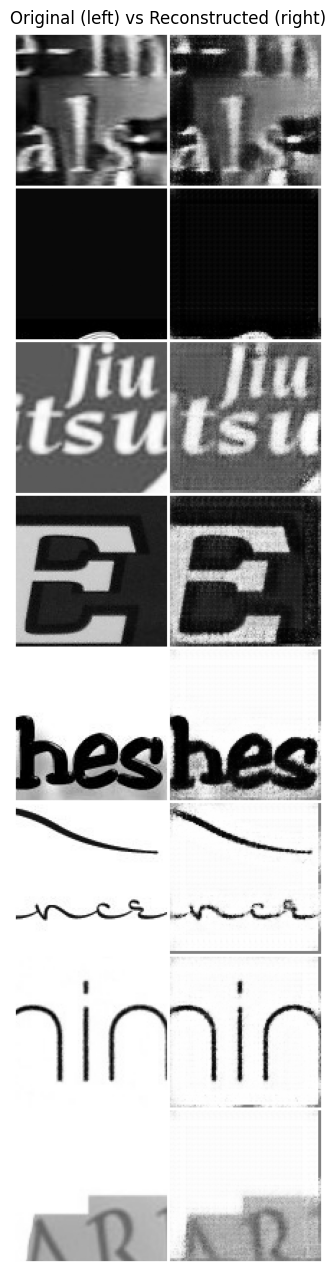

GPU memory allocated: 0.00 GB

2. Evaluating classification performance...
Model doesn't appear to have classification capability
GPU memory allocated: 0.00 GB

3. Visualizing latent space with t-SNE...
Error in latent space visualization: 'SCAE' object has no attribute 'encoder'
GPU memory allocated: 0.00 GB

4. Generating samples from latent space...
Model doesn't have a decode method. Cannot generate samples.
GPU memory allocated: 0.00 GB

5. Creating latent space interpolation...
Error during latent space interpolation: 'SCAE' object has no attribute 'encoder'
GPU memory allocated: 0.00 GB

Evaluation complete! Results saved to /kaggle/working/evaluation_results


In [11]:
# test
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from functools import partial
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import gc


def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE) 
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # Calculate SSIM (structural similarity index)
                ssim_val = ssim(img, recon, data_range=1.0)
                total_ssim += ssim_val
                
                # Calculate PSNR (peak signal-to-noise ratio)
                psnr_val = psnr(img, recon, data_range=1.0)
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    avg_mse = total_mse / (count // batch_size + 1)
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def evaluate_classification(model, dataloader, device, num_classes, save_path=None):
    """
    Evaluate classification performance if your SCAE includes classification capability
    """
    model.eval()
    
    # Check if model has a classify method or classification head
    if not hasattr(model, 'classify') and not hasattr(model, 'classification_head'):
        print("Model doesn't appear to have classification capability")
        return None
        
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions - adapt this to your model's API
            try:
                if hasattr(model, 'classify'):
                    preds = model.classify(images)
                else:
                    # Assume model returns (reconstructions, classifications) if called with return_classifications=True
                    _, preds = model(images, return_classifications=True)
                
                # Convert to class indices
                _, predicted = torch.max(preds.data, 1)
                
                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Error during classification evaluation: {e}")
                return None
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Classification Accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                if images.numel() == 0:
                    continue
                    
                images = images.to(device)
                
                # Get latent vectors - adapt this to your model's API
                if hasattr(model, 'encode'):
                    latent = model.encode(images)
                else:
                    # Try to extract the latent representation from your model
                    # This depends on your model's architecture
                    x = images
                    for layer in model.encoder:
                        x = layer(x)
                    latent = x
                
                # Flatten the latent vectors
                batch_size = images.size(0)
                latent_flat = latent.view(batch_size, -1).cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.numpy())
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        latent_vectors = np.vstack(latent_vectors)
        labels = np.concatenate(labels)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)
        
        # Plot t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, label='Font Class')
        plt.title('t-SNE Visualization of Latent Space')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
        plt.show()
        
        return latent_tsne, labels
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None

def generate_samples_from_latent(model, num_samples=10, latent_dim=128, device=None, save_path=None):
    """
    Generate new images by sampling from the latent space (like in VAE)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    
    try:
        # Generate random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Generate images
        with torch.no_grad():
            if hasattr(model, 'decode'):
                generated = model.decode(z)
            else:
                print("Model doesn't have a decode method. Cannot generate samples.")
                return None
        
        # Visualize generated images
        grid = make_grid(generated.cpu(), nrow=5, normalize=True, pad_value=1)
        plt.figure(figsize=(12, 6))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Generated Samples from Random Latent Vectors')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'generated_samples.png'), bbox_inches='tight')
        plt.show()
        
        return generated
        
    except Exception as e:
        print(f"Error generating samples from latent space: {e}")
        print(f"Your model might not support the VAE-style generation.")
        return None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        for images, _ in dataloader:
            if images.shape[0] >= 2 and images.numel() > 0:
                break
        else:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = images[0:1].to(device)
        img2 = images[1:2].to(device)
        
        # Get latent representations
        with torch.no_grad():
            if hasattr(model, 'encode'):
                z1 = model.encode(img1)
                z2 = model.encode(img2)
            else:
                # Try to extract the latent representation
                x1 = img1
                x2 = img2
                for layer in model.encoder:
                    x1 = layer(x1)
                    x2 = layer(x2)
                z1 = x1
                z2 = x2
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Decode the interpolated latent vector
                if hasattr(model, 'decode'):
                    decoded = model.decode(z_interp)
                else:
                    decoded = model.decoder(z_interp)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = [img1.cpu()]
        all_images.extend([interp.cpu() for interp in interpolations])
        all_images.append(img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "/kaggle/working/evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        test_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir, 
            bcf_file=bcf_file, 
            label_file=label_file,
            num_patch=1,  # Use fewer patches to save memory
            patch_size=(105, 105)
        )
        
        # Create test loader with smaller batch size
        collate_fn = partial(patch_collate_fn, patch_size_tuple=(105, 105))
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=32,  # Use a smaller batch size
            shuffle=True,   # Shuffle to get diverse examples
            num_workers=2,
            collate_fn=collate_fn
        )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # If model has classification capability, evaluate it
        print("\n2. Evaluating classification performance...")
        try:
            class_metrics = evaluate_classification(
                model, test_loader, device, num_classes=2383, save_path=save_dir
            )
        except:
            print("Classification evaluation skipped - model may not support classification")
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n3. Visualizing latent space with t-SNE...")
        latent_tsne, labels = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Generate samples from random latent vectors (if model supports it)
        print("\n4. Generating samples from latent space...")
        try:
            # Determine latent dimension from model structure
            # This is just a guess - adapt to your model
            latent_dim = 128
            generated_samples = generate_samples_from_latent(
                model, num_samples=16, latent_dim=latent_dim, device=device, save_path=save_dir
            )
        except:
            print("Sample generation skipped - model may not support VAE-style generation")
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n5. Creating latent space interpolation...")
        try:
            interpolations = interpolate_latent_space(
                model, test_loader, device, steps=8, save_path=save_dir
            )
        except:
            print("Latent interpolation skipped - model may not support this operation")
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [49]:
# evaluation code
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import gc
from functools import partial
from torch.utils.data import DataLoader

def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE)
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # Calculate SSIM (structural similarity index)
                ssim_val = ssim(img, recon, data_range=1.0)
                total_ssim += ssim_val
                
                # Calculate PSNR (peak signal-to-noise ratio)
                psnr_val = psnr(img, recon, data_range=1.0)
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    avg_mse = total_mse / (count // batch_size + 1)
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def extract_latent_features(model, x):
    """
    Extract latent features from the model by running through the encoder part only
    Adapted specifically for the new SCAE architecture
    """
    # Apply encoder operations manually based on your model's structure
    x = model.conv1(x)
    x = model.norm1(x)
    x = model.act1(x)
    x = model.drop1(x)
    x, indices = model.pool1(x)
    x = model.conv2(x)
    x = model.norm2(x)
    x = model.act2(x)
    x = model.drop2(x)
    return x, indices

def generate_from_latent(model, latent, indices, output_size):
    """
    Generate images from latent features by running through the decoder part only
    Adapted specifically for the new SCAE architecture
    """
    # Apply decoder operations manually based on your model's structure
    x = model.deconv1(latent)
    x = model.norm3(x)
    x = model.act3(x)
    x = model.drop3(x)
    x = model.unpool1(x, indices, output_size=output_size)
    x = model.deconv2(x)
    x = model.final_act(x)
    return x

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        orig_shapes = []
        indices_list = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                if images.numel() == 0:
                    continue
                    
                images = images.to(device)
                
                # Get latent vectors using our custom function
                latent, indices = extract_latent_features(model, images)
                
                # Flatten the latent vectors for t-SNE
                batch_size = images.size(0)
                latent_flat = latent.view(batch_size, -1).cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.numpy())
                
                # Store original shapes and indices for potential reconstruction
                for i in range(batch_size):
                    orig_shapes.append(torch.Size([1, latent.size(1), latent.size(2), latent.size(3)]))
                    indices_list.append(indices[i:i+1])
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        latent_vectors = np.vstack(latent_vectors)
        labels = np.concatenate(labels)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)
        
        # Plot t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, label='Font Class')
        plt.title('t-SNE Visualization of Latent Space')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
        plt.show()
        
        return latent_tsne, labels, latent_vectors, orig_shapes, indices_list
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None, None, None, None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    Adapted for the new SCAE architecture
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        for images, _ in dataloader:
            if images.shape[0] >= 2 and images.numel() > 0:
                break
        else:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = images[0:1].to(device)
        img2 = images[1:2].to(device)
        
        # Get latent representations and indices for unpooling
        with torch.no_grad():
            z1, indices1 = extract_latent_features(model, img1)
            z2, indices2 = extract_latent_features(model, img2)
        
        # Get output size for the unpool operation
        output_size = torch.Size([1, z1.size(1), 48, 48])  # Based on your architecture
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Use indices from first image for interpolation (simplification)
                decoded = generate_from_latent(model, z_interp, indices1, output_size)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = []
        with torch.no_grad():
            # Add the first original image
            all_images.append(img1.cpu())
            # Add interpolations
            all_images.extend([interp.cpu() for interp in interpolations])
            # Add the second original image
            all_images.append(img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:
        # Import necessary modules - add these imports here to avoid issues in Kaggle
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        combined_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir,
            bcf_file=bcf_file,
            label_file=label_file,
            num_patch=3,  # Reduced from 3
        )
    
        # Create memory-optimized dataloaders with smaller batch size
        test_loader, val_loader = create_optimized_dataloaders(
            combined_dataset,
            batch_size=512,  # Reduced from 1024
            num_workers=2,   # Reduced from 4
            val_split=0
        )
        # test_dataset = CombinedImageDataset(
        #     jpeg_dir=jpeg_dir, 
        #     bcf_file=bcf_file, 
        #     label_file=label_file,
        #     num_patch=3,  # Use fewer patches to save memory
        #     patch_size=(105, 105)
        # )
        
        # # Create test loader with smaller batch size
        # collate_fn = partial(patch_collate_fn, patch_size_tuple=(105, 105))
        # test_loader = DataLoader(
        #     test_dataset,
        #     batch_size=128,  # Use a smaller batch size
        #     shuffle=True,   # Shuffle to get diverse examples
        #     num_workers=2,
        #     collate_fn=collate_fn
        # )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n2. Visualizing latent space with t-SNE...")
        latent_tsne, labels, latent_vectors, orig_shapes, indices_list = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n3. Creating latent space interpolation...")
        interpolations = interpolate_latent_space(
            model, test_loader, device, steps=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Using device: cuda
Model loaded successfully


/tmp/ipykernel_31/2542586318.py:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 82389 .jpeg images.
Loaded 3202 labels from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label.
Loaded 3202 images from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf.
Loaded 3202 .bcf images.
Dataset and DataLoader prepared

1. Evaluating reconstruction quality...
Error during evaluation: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 418, in __getitems__
    return self.dataset.__getitems

Traceback (most recent call last):
  File "/tmp/ipykernel_31/2542586318.py", line 341, in main
    recon_metrics = evaluate_reconstruction(
                    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_31/2542586318.py", line 40, in evaluate_reconstruction
    for images, _ in dataloader:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1465, in _next_data
    return self._process_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1491, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.11/dist-packages/torch/_utils.py", line 715, in reraise
    raise exception
TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/pyt

Using device: cuda
Model loaded successfully


/tmp/ipykernel_31/939787542.py:485: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 82389 .jpeg images.
Loaded 3202 labels from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label.
Loaded 3202 images from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf.
Loaded 3202 .bcf images.
Dataset and DataLoader prepared

1. Evaluating reconstruction quality...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1e667d6160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1e667d6160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Reconstruction Metrics:
  Average MSE: 0.0026
  Average SSIM: 0.9203 (higher is better, max 1.0)
  Average PSNR: 26.56 dB (higher is better)
Saved reconstruction comparison to evaluation_results


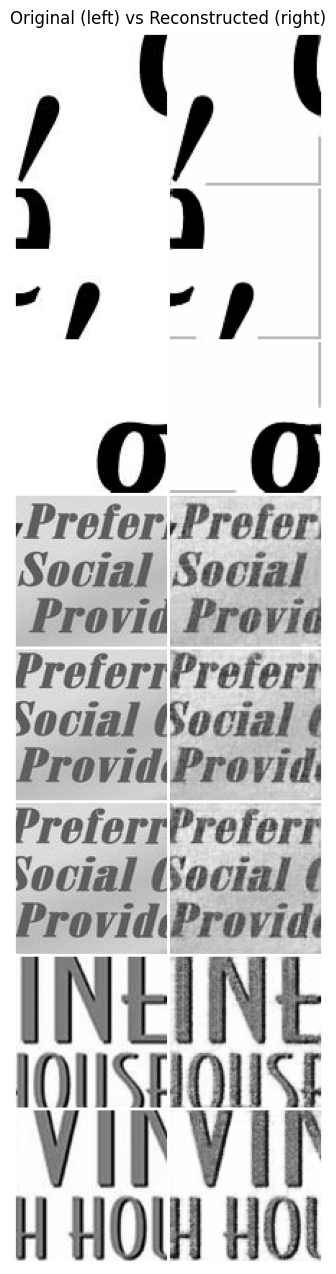

GPU memory allocated: 0.00 GB

2. Visualizing latent space with t-SNE...
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)

Error in latent space visualization: cannot unpack non-iterable NoneType object
GPU memory allocated: 0.00 GB

3. Creating latent space interpolation...
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride =

Traceback (most recent call last):
  File "/tmp/ipykernel_31/939787542.py", line 404, in interpolate_latent_space
    z1, indices1 = safely_extract_latent_features(model, img1)
    ^^^^^^^^^^^^
TypeError: cannot unpack non-iterable NoneType object


In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import gc
from functools import partial
from torch.utils.data import DataLoader

def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE)
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            # Skip empty batches
            if images.numel() == 0:
                continue
                
            # Ensure we have the right shape for processing
            if len(images.shape) == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions if needed)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # If image has 3 channels, convert to grayscale for SSIM/PSNR calculation
                if len(img.shape) == 3 and img.shape[0] == 3:
                    img_gray = np.mean(img, axis=0)
                    recon_gray = np.mean(recon, axis=0)
                    ssim_val = ssim(img_gray, recon_gray, data_range=1.0)
                    psnr_val = psnr(img_gray, recon_gray, data_range=1.0)
                else:
                    # Ensure images are properly squeezed but retain needed dimensions
                    if len(img.shape) > 2:
                        img = np.squeeze(img)
                    if len(recon.shape) > 2:
                        recon = np.squeeze(recon)
                    
                    # Handle case where squeeze removed too many dimensions
                    if len(img.shape) == 0:
                        img = img.reshape(1, 1)
                    if len(recon.shape) == 0:
                        recon = recon.reshape(1, 1)
                        
                    ssim_val = ssim(img, recon, data_range=1.0)
                    psnr_val = psnr(img, recon, data_range=1.0)
                
                total_ssim += ssim_val
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    if count > 0:
        avg_mse = total_mse / (count // batch_size + 1)
        avg_ssim = total_ssim / count
        avg_psnr = total_psnr / count
    else:
        avg_mse = float('nan')
        avg_ssim = float('nan')
        avg_psnr = float('nan')
        print("Warning: No valid samples were processed in evaluation")
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def safely_extract_latent_features(model, x):
    """
    Extract latent features from the model - with safety checks and error handling
    Handles various model architectures by attempting different approaches
    """
    try:
        # Method 1: Direct call to encoder if available
        if hasattr(model, 'encode'):
            return model.encode(x)
        
        # Method 2: Manual application of encoder layers as in original code
        # Capture as much as possible through a try/except approach
        try:
            x = model.conv1(x)
            x = model.norm1(x) if hasattr(model, 'norm1') else x
            x = model.act1(x) if hasattr(model, 'act1') else torch.relu(x)
            x = model.drop1(x) if hasattr(model, 'drop1') else x
            
            # Handle pooling layers with or without indices
            if hasattr(model, 'pool1'):
                if 'MaxPool' in model.pool1.__class__.__name__ and 'return_indices=True' in str(model.pool1):
                    x, indices = model.pool1(x)
                else:
                    x = model.pool1(x)
                    indices = None
            else:
                indices = None
                
            # Continue with more layers if they exist
            if hasattr(model, 'conv2'):
                x = model.conv2(x)
                x = model.norm2(x) if hasattr(model, 'norm2') else x
                x = model.act2(x) if hasattr(model, 'act2') else torch.relu(x)
                x = model.drop2(x) if hasattr(model, 'drop2') else x
            
            return x, indices
            
        except Exception as e:
            print(f"Warning: Error in manual feature extraction: {e}")
            
            # Method 3: Simplified approach - extract features up to a bottleneck
            # This is a more generic approach that can work with different model architectures
            features = []
            indices_list = []
            
            # Get all model's modules
            for name, module in model.named_modules():
                # Skip the top level module (the model itself)
                if name == '':
                    continue
                    
                # Apply the layer
                try:
                    if isinstance(module, nn.MaxPool2d) and module.return_indices:
                        x, indices = module(x)
                        indices_list.append(indices)
                    else:
                        x = module(x)
                        
                    # Collect features at bottleneck or certain layers
                    if isinstance(module, (nn.Conv2d, nn.Linear)) and len(features) < 5:
                        features.append(x)
                        
                    # If we've reached the bottleneck/middle of the network, stop
                    if 'bottleneck' in name.lower() or 'latent' in name.lower():
                        break
                        
                except Exception:
                    continue
            
            # If we've collected features, return the last one
            if features:
                return features[-1], indices_list[-1] if indices_list else None
    
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        # Return input as fallback (will produce poor results but prevents crashes)
        return x, None

def safely_generate_from_latent(model, latent, indices=None, output_size=None):
    """
    Generate images from latent features with safety checks and error handling
    Handles various model architectures by attempting different approaches
    """
    try:
        # Method 1: Direct call to decoder if available
        if hasattr(model, 'decode'):
            return model.decode(latent)
        
        # Method 2: Manual application of decoder layers as in original code
        try:
            x = latent
            
            # Apply decoder operations based on model attributes
            if hasattr(model, 'deconv1'):
                x = model.deconv1(x)
                x = model.norm3(x) if hasattr(model, 'norm3') else x
                x = model.act3(x) if hasattr(model, 'act3') else torch.relu(x)
                x = model.drop3(x) if hasattr(model, 'drop3') else x
            
            # Handle unpooling layers if they exist
            if hasattr(model, 'unpool1') and indices is not None:
                x = model.unpool1(x, indices, output_size=output_size)
            
            # Continue with more layers if they exist
            if hasattr(model, 'deconv2'):
                x = model.deconv2(x)
            
            # Apply final activation if it exists
            if hasattr(model, 'final_act'):
                x = model.final_act(x)
            elif hasattr(model, 'sigmoid'):
                x = model.sigmoid(x)
            else:
                x = torch.sigmoid(x)  # Default to sigmoid for image generation
                
            return x
            
        except Exception as e:
            print(f"Warning: Error in manual latent generation: {e}")
            
            # Method 3: Forward pass through the full model as fallback
            # This is a reasonable fallback that should work with most autoencoders
            return model(latent)
    
    except Exception as e:
        print(f"Error in generating from latent: {e}")
        # Return latent as fallback (will produce poor results but prevents crashes)
        return latent

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        orig_shapes = []
        indices_list = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                # Skip empty batches
                if images.numel() == 0:
                    continue
                    
                # Ensure we have the right shape for processing
                if len(images.shape) == 3:
                    images = images.unsqueeze(1)  # Add channel dimension if missing
                    
                images = images.to(device)
                
                # Get latent vectors using our safe extraction function
                latent, indices = safely_extract_latent_features(model, images)
                
                # Flatten the latent vectors for t-SNE
                batch_size = images.size(0)
                
                # Handle case where latent is not a tensor
                if not isinstance(latent, torch.Tensor):
                    print("Warning: Latent features are not a tensor, skipping batch")
                    continue
                
                # Flatten the latent representations
                if len(latent.shape) > 2:
                    latent_flat = latent.reshape(batch_size, -1).cpu().numpy()
                else:
                    latent_flat = latent.cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.cpu().numpy())
                
                # Store original shapes and indices for potential reconstruction
                for i in range(batch_size):
                    if indices is not None:
                        if isinstance(indices, list):
                            indices_list.append([idx[i:i+1] for idx in indices])
                        else:
                            indices_list.append(indices[i:i+1])
                    else:
                        indices_list.append(None)
                    
                    if len(latent.shape) > 2:
                        orig_shapes.append(torch.Size([1, latent.size(1), latent.size(2), latent.size(3)]))
                    else:
                        # Handle case where latent is already flattened
                        orig_shapes.append(None)
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        if latent_vectors:
            latent_vectors = np.vstack(latent_vectors)
            labels = np.concatenate(labels)
            
            # Apply t-SNE
            tsne = TSNE(n_components=2, random_state=42)
            latent_tsne = tsne.fit_transform(latent_vectors)
            
            # Plot t-SNE results
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
            plt.colorbar(scatter, label='Font Class')
            plt.title('t-SNE Visualization of Latent Space')
            
            if save_path:
                plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
            plt.show()
            
            return latent_tsne, labels, latent_vectors, orig_shapes, indices_list
        else:
            print("No valid latent vectors were extracted")
            return None, None, None, None, None
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None, None, None, None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    With improved error handling and support for different model architectures
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        valid_images = []
        
        for images, _ in dataloader:
            # Skip empty batches
            if images.numel() == 0:
                continue
                
            # Ensure we have the right shape for processing
            if len(images.shape) == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
                
            valid_images.append(images)
            
            if len(valid_images) > 0 and valid_images[0].shape[0] >= 2:
                break
        
        if not valid_images or valid_images[0].shape[0] < 2:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = valid_images[0][0:1].to(device)
        img2 = valid_images[0][1:2].to(device)
        
        # Get latent representations and indices for unpooling
        with torch.no_grad():
            z1, indices1 = safely_extract_latent_features(model, img1)
            z2, indices2 = safely_extract_latent_features(model, img2)
            
            # Check if latent features were extracted correctly
            if z1 is None or z2 is None:
                print("Failed to extract latent features for interpolation")
                return None
        
        # Get output size for the unpool operation if needed
        # This is a reasonable default that should work with many architectures
        if len(z1.shape) == 4:
            output_size = torch.Size([1, z1.size(1), z1.size(2)*2, z1.size(3)*2])
        else:
            output_size = None
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                # Linear interpolation in latent space
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Use indices from first image for interpolation (simplification)
                decoded = safely_generate_from_latent(model, z_interp, indices1, output_size)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = []
        with torch.no_grad():
            # Add the first original image
            reconstructed_img1 = model(img1)
            all_images.append(reconstructed_img1.cpu())
            
            # Add interpolations
            all_images.extend([interp.cpu() for interp in interpolations])
            
            # Add the second original image
            reconstructed_img2 = model(img2)
            all_images.append(reconstructed_img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        import traceback
        traceback.print_exc()
        return None

def main():
    """
    Main evaluation function that runs all the evaluation steps
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths - make these configurable in your actual implementation
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:        
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        combined_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir,
            bcf_file=bcf_file,
            label_file=label_file,
            num_patch=3,
        )
    
        # Create dataloaders using our fixed implementation
        test_loader, val_loader = create_patch_dataloaders(
            combined_dataset,
            batch_size=64,  # Reduced batch size for better stability
            num_workers=2,
            val_split=0.1,
            patch_size=(105, 105)
        )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n2. Visualizing latent space with t-SNE...")
        latent_tsne, labels, latent_vectors, orig_shapes, indices_list = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n3. Creating latent space interpolation...")
        interpolations = interpolate_latent_space(
            model, test_loader, device, steps=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [16]:
!zip -r /kaggle/working/evaluation_results.zip /kaggle/working/evaluation_results

  adding: kaggle/working/evaluation_results/ (stored 0%)
  adding: kaggle/working/evaluation_results/latent_interpolation.png (deflated 5%)
  adding: kaggle/working/evaluation_results/latent_tsne.png (deflated 2%)
  adding: kaggle/working/evaluation_results/reconstruction_comparison.png (deflated 4%)


# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [ ]:
# augmentation functions
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img

def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian